In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import seaborn as sns
from pathlib import Path

plt.rcParams["figure.figsize"] = (15,5)

## UTILITY FUNCTIONS

`load_csv(path, skiprows)` carica from `path` il file _csv_ saltando le prime `skiprows` righe

In [2]:
def load_csv(path, skip_rows=1):
  return pd.read_csv(path, skiprows=skip_rows, sep=',').r.values

`compute_moving_avg_rewards(rewards, moving_avg_window_size)` calcola la media mobile dell'array delle rewards `rewards` con una finestra grande `moving_avg_windows_size` 

In [3]:
def compute_moving_avg_rewards(rewards, moving_avg_window_size=100):
  return np.convolve(rewards, np.ones(moving_avg_window_size)/moving_avg_window_size, mode='valid')

`plot_rewards(data, label, limit_data=5000)` grafica le rewards specificate in `data` con la corrispondente `label`, limitando i dati con `limit_data`

In [4]:
def plot_rewards(data, label):
  plt.plot(data, label=[label])
  plt.xlabel('Episodes')
  plt.ylabel('Rewards')

`first_time_value_reached(data, value)` restituisce l'indice della posizione in cui `value` è >= di `data[i]`, `min_threshold` serve per evitare che ci siano valori molto alti di media all'inizio

In [5]:
def first_time_value_reached(data, value):
  index = np.argmax(data > value)
  return None if index == 0 else index

`compute_speedup(initial_value, final_value)` calcola in percentuale l'incremento di `value_1` rispetto a `value_2` 

In [6]:
def compute_speedup(value_1, value_2):
  if value_1 is None or value_2 is None:
    return np.inf
  min_value = min(value_1, value_2)
  if min_value == 0:
    return np.inf
  return round( abs(value_1 - value_2) / min_value * 100, ndigits=2)

`plot_together(list_of_csv, moving_avg_windows_size=100, limit_data=5000, first_value_reached=20)` grafica l'elenco specificato di csv in `list_of_csv`, computa di ciascuno di essi la moving average utilizzando come finestra `moving_avg_windows_size` e limitando i dati a `limit_data` elementi. 


In [7]:
def plot_together(list_of_csv, limit_data=5000, moving_avg_windows_size=100, first_value_reached=20):
  csvs = [load_csv(csv)[:limit_data] for csv in list_of_csv]
  algos = [Path(csv).stem for csv in list_of_csv]
  moving_avgs = np.array([compute_moving_avg_rewards(csv, moving_avg_windows_size) for csv in csvs])
  data = {algo : averages for algo, averages in zip(algos, moving_avgs)}
  indexes = {algo : first_time_value_reached(avg, first_value_reached) for algo, avg in zip(algos, moving_avgs)}
  sorted_indexes = dict(sorted(indexes.items(), key=lambda x: (x[1] is None, x[1])))
  color_seq = plt.rcParams['axes.prop_cycle'].by_key()['color']

  print(f"Moving average over {first_value_reached} for the first time:")
  for index, algo in sorted_indexes.items():
    print(algo, index)
  print()

  print("Speed up:")
  for i, (algo, faster_avg) in enumerate(list(sorted_indexes.items())[:-1], start=1):
    print(algo)
    for algo, slower_avg in list(sorted_indexes.items())[i:]:
      speed_up = compute_speedup(faster_avg, slower_avg)
      print(f'\t{algo}: {speed_up}%')

  for algo, moving_avg in data.items():
    plt.title('All models rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.plot(moving_avg)
  
  plt.legend(data.keys())

  for color, index in zip(color_seq, indexes.values()):
    if index is not None:
      plt.axvline(x = index, color = color, linestyle = 'dashed')
      plt.annotate(index, (index, first_value_reached))

  plt.axhline(20, color = 'gray', linestyle = 'dashed')

`compare_last_n_games(list_of_csv, lasts_n_games=50)` mosta un confronto tra gli ultimi `lasts_n_games` caricando le rewards da `list_of_csv`

In [8]:
def compare_last_n_games(list_of_csv, lasts_n_games=50):
  mean_last_n_games = [np.mean(load_csv(csv)[-lasts_n_games:]) for csv in list_of_csv]
  dataframe = pd.DataFrame({
      'average_score' : mean_last_n_games,
      'algorithm' : [Path(csv).stem for csv in list_of_csv]
  }).sort_values('average_score', ascending=False)
  ax = sns.barplot(data=dataframe, x=f'average_score', y='algorithm')
  ax.bar_label(ax.containers[0])

`filter_csv(regex='')` carica i _csv_ in base alla regex passata (N.B. quest'ultima non deve includere `.csv`)

In [9]:
def filter_csv(regex=''):
  return glob(regex + '.csv')

## DOWNLOAD

Download delle rewards

In [10]:
!wget  https://sitolorenzogardini.altervista.org/csvs/rewards.zip
!wget  https://sitolorenzogardini.altervista.org/csvs/fails.zip

!unzip rewards.zip
!unzip fails.zip

!rm rewards.zip
!rm fails.zip

--2023-04-05 13:24:13--  https://sitolorenzogardini.altervista.org/csvs/rewards.zip
Resolving sitolorenzogardini.altervista.org (sitolorenzogardini.altervista.org)... 157.90.1.124
Connecting to sitolorenzogardini.altervista.org (sitolorenzogardini.altervista.org)|157.90.1.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1756430 (1.7M) [application/zip]
Saving to: ‘rewards.zip’

rewards.zip         100%[===================>]   1.67M   552KB/s    in 3.1s    

2023-04-05 13:24:17 (552 KB/s) - ‘rewards.zip’ saved [1756430/1756430]

--2023-04-05 13:24:17--  https://sitolorenzogardini.altervista.org/csvs/fails.zip
Resolving sitolorenzogardini.altervista.org (sitolorenzogardini.altervista.org)... 157.90.1.124
Connecting to sitolorenzogardini.altervista.org (sitolorenzogardini.altervista.org)|157.90.1.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7564689 (7.2M) [application/zip]
Saving to: ‘fails.zip’

fails.zip           100%[======

## PLOTS

Caricamento per categoria dei file di configurazione

In [11]:
stable_baselines_files = filter_csv('sb3_*')
stable_baselines_ok = [f'sb3_{algo}.csv' for algo in ['A2C_16', 'PPO_8', 'DQN_1']]
stable_baselines_bad = [f'sb3_{algo}.csv' for algo in ['A2C_1', 'PPO_1', 'DQN_16']]
fails = filter_csv('fail_*')
tf_agents = filter_csv('tf_*')

Plot dei migliori risultati ottenuti utilizzando Stable Baselines 3

Moving average over 20 for the first time:
1084 sb3_PPO_8
4182 sb3_DQN_1
5292 sb3_A2C_16

Speed up:
sb3_PPO_8
	sb3_DQN_1: 285.79%
	sb3_A2C_16: 388.19%
sb3_DQN_1
	sb3_A2C_16: 26.54%


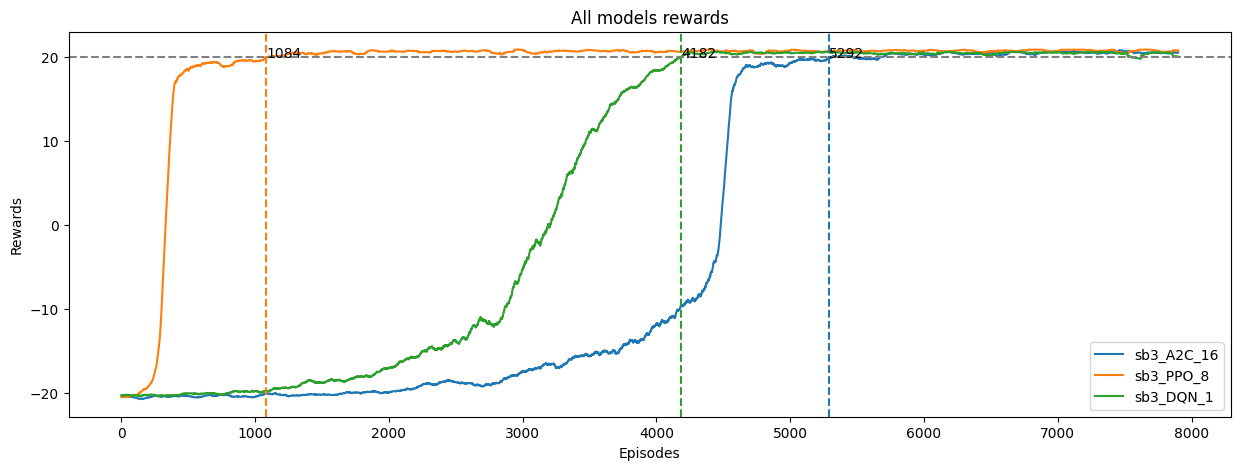

In [12]:
plot_together(stable_baselines_ok, 8_000)

Plot degli algoritmi utilizzando gli algoritmi con un numero scorretto di evironments

Moving average over 20 for the first time:
1637 sb3_PPO_1
7617 sb3_DQN_16
None sb3_A2C_1

Speed up:
sb3_PPO_1
	sb3_DQN_16: 365.3%
	sb3_A2C_1: inf%
sb3_DQN_16
	sb3_A2C_1: inf%


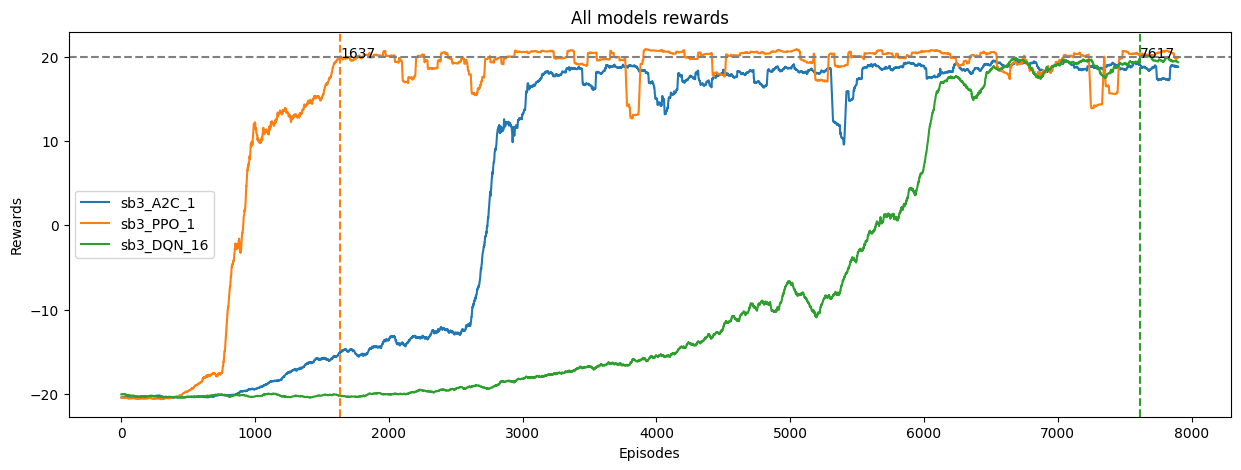

In [13]:
plot_together(stable_baselines_bad, 8_000)

Confronto tra tutti gli algoritmi di Stable Baselines 3

Moving average over 20 for the first time:
1084 sb3_PPO_8
1637 sb3_PPO_1
4182 sb3_DQN_1
5292 sb3_A2C_16
7617 sb3_DQN_16
None sb3_A2C_1

Speed up:
sb3_PPO_8
	sb3_PPO_1: 51.01%
	sb3_DQN_1: 285.79%
	sb3_A2C_16: 388.19%
	sb3_DQN_16: 602.68%
	sb3_A2C_1: inf%
sb3_PPO_1
	sb3_DQN_1: 155.47%
	sb3_A2C_16: 223.27%
	sb3_DQN_16: 365.3%
	sb3_A2C_1: inf%
sb3_DQN_1
	sb3_A2C_16: 26.54%
	sb3_DQN_16: 82.14%
	sb3_A2C_1: inf%
sb3_A2C_16
	sb3_DQN_16: 43.93%
	sb3_A2C_1: inf%
sb3_DQN_16
	sb3_A2C_1: inf%


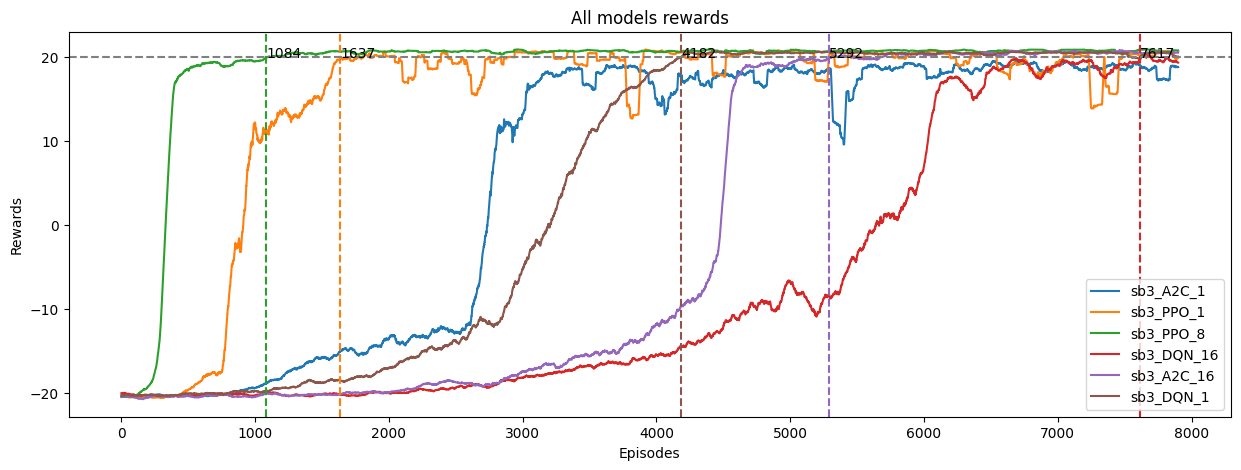

In [14]:
plot_together(stable_baselines_files, 8_000)

Plot di tutti gli algoritmi che non hanno portato buoni risultati causati dallo `StickyActionEnv`

Moving average over 20 for the first time:
None fail_sb3_PPO_8
None fail_sb3_DQN_8
None fail_sb3_A2C_16

Speed up:
fail_sb3_PPO_8
	fail_sb3_DQN_8: inf%
	fail_sb3_A2C_16: inf%
fail_sb3_DQN_8
	fail_sb3_A2C_16: inf%


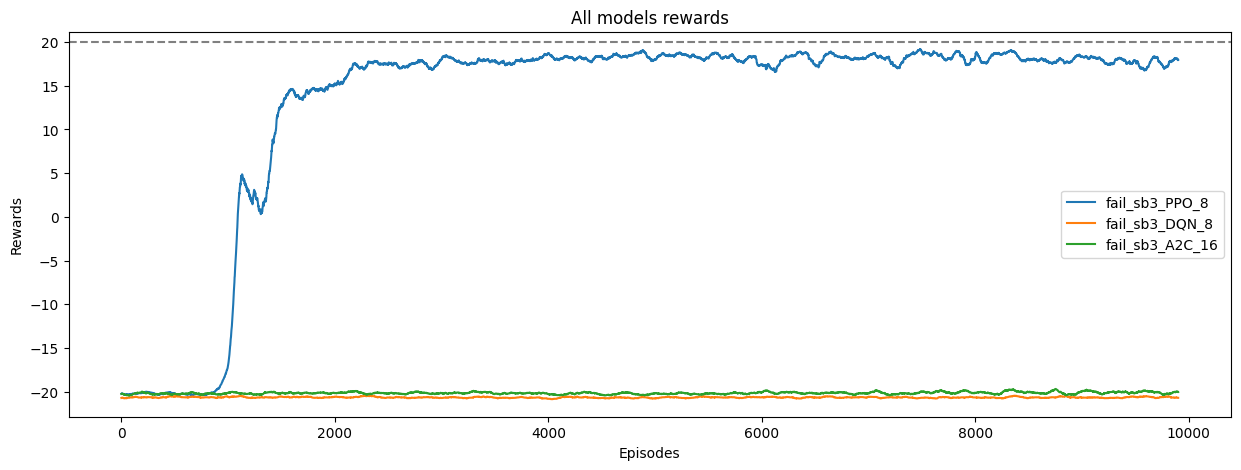

In [15]:
plot_together(fails, 10_000)

Plot dei risultati ottenuti con Tensorflow Agents

<ipython-input-7-a93a3a6c0f8d>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  moving_avgs = np.array([compute_moving_avg_rewards(csv, moving_avg_windows_size) for csv in csvs])


Moving average over 20 for the first time:
2755 tf_DDQN
2829 tf_DQN
2867 tf_DDQN_Dueling
2898 tf_DQN_Dueling

Speed up:
tf_DDQN
	tf_DQN: 2.69%
	tf_DDQN_Dueling: 4.07%
	tf_DQN_Dueling: 5.19%
tf_DQN
	tf_DDQN_Dueling: 1.34%
	tf_DQN_Dueling: 2.44%
tf_DDQN_Dueling
	tf_DQN_Dueling: 1.08%


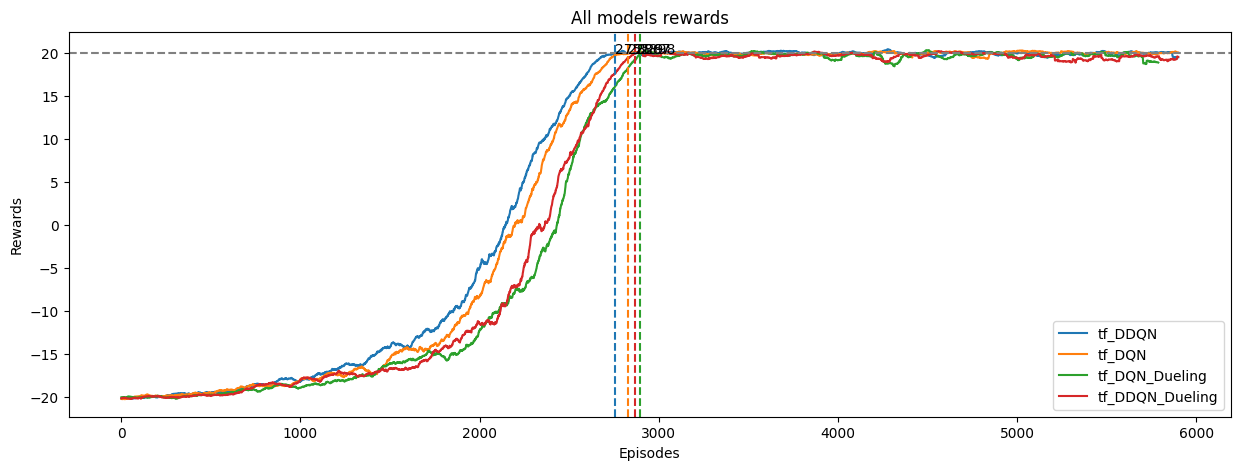

In [16]:
plot_together(tf_agents, 6_000)

Plot del confronto tra i migliori risultati tra Stable Baselines 3 e Tensorflow Agents

Moving average over 20 for the first time:
1084 sb3_PPO_8
2755 tf_DDQN
2829 tf_DQN
4182 sb3_DQN_1
5292 sb3_A2C_16

Speed up:
sb3_PPO_8
	tf_DDQN: 154.15%
	tf_DQN: 160.98%
	sb3_DQN_1: 285.79%
	sb3_A2C_16: 388.19%
tf_DDQN
	tf_DQN: 2.69%
	sb3_DQN_1: 51.8%
	sb3_A2C_16: 92.09%
tf_DQN
	sb3_DQN_1: 47.83%
	sb3_A2C_16: 87.06%
sb3_DQN_1
	sb3_A2C_16: 26.54%


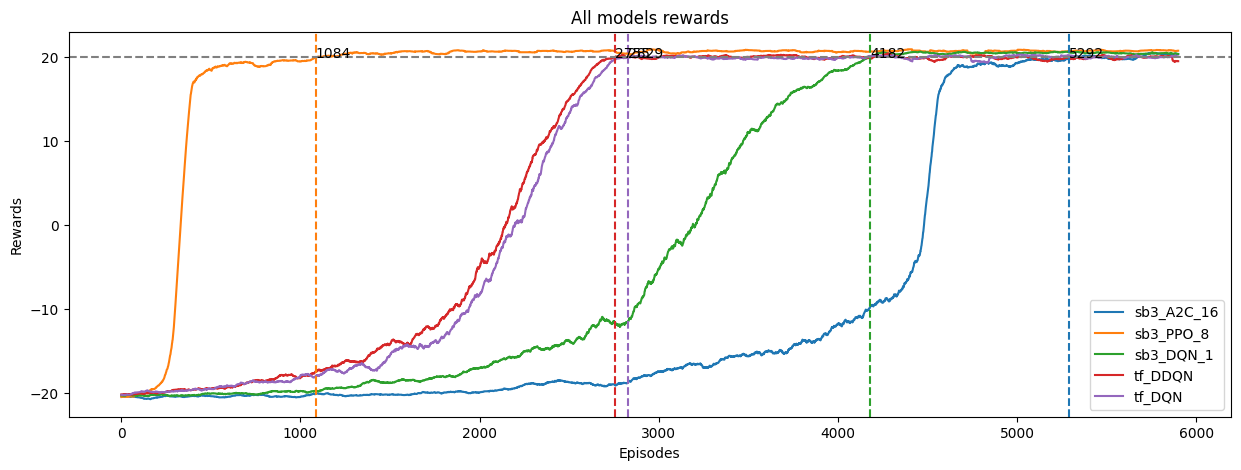

In [17]:
plot_together(stable_baselines_ok + ['tf_DDQN.csv', 'tf_DQN.csv'], limit_data=6000)

Media raggiunta nelle ultime N partite da ciascun algoritmo a confronto

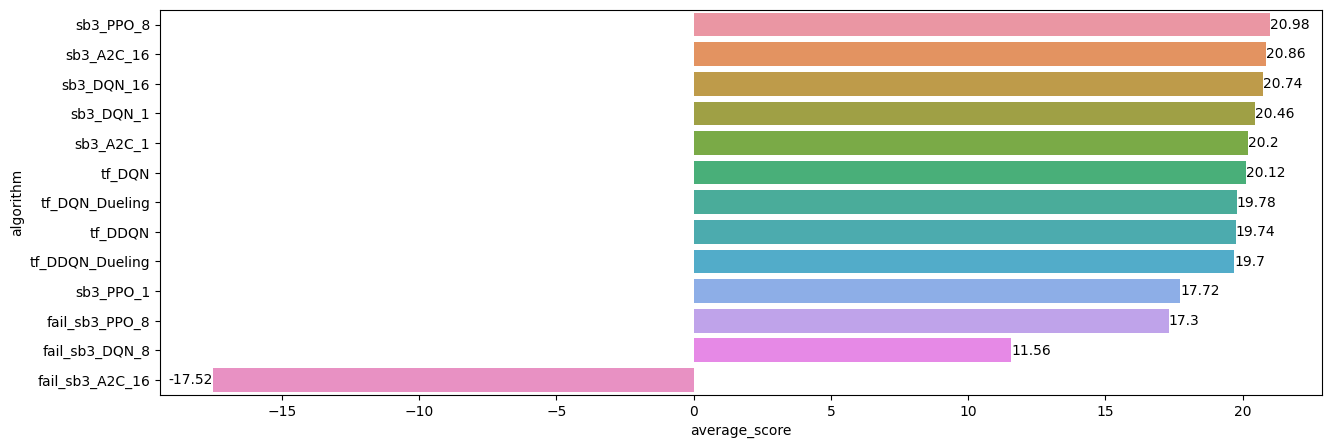

In [18]:
compare_last_n_games(glob('*.csv'), lasts_n_games=50)